In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from bicycle.model import BICYCLE
from pathlib import Path
import matplotlib.pyplot as plt
from bicycle.utils.mask_utils import get_sparsity, above_threshold, string_to_list
import json
from glob import glob
from scipy.special import expit
import scanpy as sc
import re
from bicycle.utils.data import create_loaders
from scipy.stats.stats import ttest_ind, ttest_rel


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: 

In [2]:
def evaluate_model(model, key, models_path, **kwargs):
    samples = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_samples.npy"))
    sim_regime = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_regimes.npy"))
    train_gene_ko = model.train_gene_ko
    test_gene_ko = model.test_gene_ko
    if len(test_gene_ko)>20:
        overhang = len(test_gene_ko)-20
        print(f"More than 20 test_genes! Removing last {overhang} contexts.")
        regimes = sim_regime.unique()[-overhang:]
        for regime in regimes:
            mask = sim_regime != regime
            samples = samples[mask]
            sim_regime = sim_regime[mask]
        test_gene_ko = test_gene_ko[:-overhang]
    train_loader, validation_loader, test_loader = create_loaders(
        samples=samples, # test_loader is None
        sim_regime=sim_regime,
        validation_size=kwargs.get("validation_size", 0.),
        batch_size=kwargs.get("batch_size", 100000),
        SEED= kwargs.get("SEED", 1),
        train_gene_ko=train_gene_ko,
        test_gene_ko=test_gene_ko,
        persistent_workers=False,
        covariates=None,
        num_workers= 1,
    )
    return model.evaluate(test_loader.dataset, **kwargs)

In [3]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg8(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params["data_id"]+params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg_paper(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params[param_of_interest] + " + " + params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg(params, param_of_interest):
    params = params.sort_index()
    if type(param_of_interest) is dict:
        params["config"] = params[param_of_interest["0"]] + " + " + params[param_of_interest["1"]]
        index = params.isna()["config"]
        params.loc[index,"config"] = params.loc[index, param_of_interest["0"]]
        param_of_interest = "config"
        params.sort_values(param_of_interest)
    return params, param_of_interest

functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
    "agg8":agg8,
    "agg_paper":agg_paper,
    "agg": agg,
             }

In [4]:
save = True


In [5]:
experiment = "scale_mask_scMultiSim"
id_len = 3
prefix = "run_"
param_of_interest = "masking_mode"
agg = None

#include = np.array([98,99])
#id_len = 3
#prefix = "run_"
#experiment = None
#param_of_interest = "data_source"
#agg = None
print(f"Experiment: {experiment}")
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/experiments/")/experiment
figures_path = Path("../../../presentation/")/experiment
if not figures_path.exists():
    figures_path.mkdir()
data_path = Path("./data/")
columns = [
    "model_lr",
    "model_n_genes",
    "model_n_samples",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id",
    "data_source",
    "model_use_latents",
    "n1",
    "n2",
    "data_sem",
    "n"
    ]
if not param_of_interest in columns and not type(param_of_interest) is dict:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
elif isinstance(param_of_interest, dict):
     for item in param_of_interest.values():
        if item not in columns:
            columns.append(item)
params = pd.DataFrame(columns=columns)
for dir in models_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    print(dir.name)
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan

if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)

Experiment: scale_mask_scMultiSim
run_007
run_027
run_083
run_098
run_055
run_025
run_088
run_005
run_062
run_010
run_040
run_072
run_001
run_043
run_094
run_033
run_076
run_065
run_047
run_066
run_097
run_012
run_034
run_038
run_011
run_064
run_071
run_078
run_092
run_081
run_070
run_079
run_032
run_002
run_084
run_037
run_089
run_053
run_074
run_045
run_041
run_030
run_029
run_019
run_082
run_087
run_006
run_051
run_042
run_023
run_095
run_016
run_057
run_058
run_093
run_048
run_017
run_061
run_009
run_080
run_073
run_069
run_035
run_060
run_014
run_099
run_039
run_046
run_015
run_044
run_020
run_077
run_026
run_003
run_059
run_021
run_050
run_036
run_031
run_075
run_090
run_052
run_022
run_096
run_049
run_067
run_004
run_024
run_008
run_000
run_068
run_013
run_018
run_063
run_086
run_056
run_054
run_085
run_091
run_028


In [6]:
ckpts = dict()
for path in models_path.iterdir():
    key = str(path.name)
    if path.name[:-id_len] != prefix:
         continue
    
    paths = glob(root_dir=path/"customcheckpoint", pathname="./last*.ckpt")
    try:
        paths.remove('./last.ckpt')
    except:
        print(f"{key} has no last.ckpt")
        params = params.drop(index=key)
        continue

    if len(paths) ==0:
        print("using last")
        ckpt_path = path / "customcheckpoint/last.ckpt"
        if not ckpt_path.exists():
            params = params.drop(index=key)

            continue
    else:
        ckpt_path = path / "customcheckpoint"/ max(paths)
        print(ckpt_path)
    print(key)
    state = torch.load(ckpt_path, weights_only=False, map_location="cpu")
    print("last epoch: ",state["epoch"])
    if state["epoch"]<1000:
         print(f"{key} only has {state['epoch']} epoch.\nWill be removed...")
         params = params.drop(index=key)
         continue
    model = BICYCLE.load_from_checkpoint(ckpt_path).to("cpu")


    ckpts[key] = model
'''    with torch.no_grad():
        grn = model.gt_beta.copy()
        ckpts[key]["grn"] = grn
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[key]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()
        if not model.bayes_prior is None:
            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()
'''

using last
run_007
last epoch:  4999
Initializing parameters from data
using last
run_027
last epoch:  4999
Initializing parameters from data
using last
run_083
last epoch:  4999
Initializing parameters from data
using last
run_098
last epoch:  4999
Initializing parameters from data
using last
run_055
last epoch:  4999
Initializing parameters from data
using last
run_025
last epoch:  4999
Initializing parameters from data
using last
run_088
last epoch:  4999
Initializing parameters from data
using last
run_005
last epoch:  4999
Initializing parameters from data
using last
run_062
last epoch:  4999
Initializing parameters from data
using last
run_010
last epoch:  4999
Initializing parameters from data
using last
run_040
last epoch:  4999
Initializing parameters from data
using last
run_072
last epoch:  4999
Initializing parameters from data
using last
run_001
last epoch:  4999
Initializing parameters from data
using last
run_043
last epoch:  4999
Initializing parameters from data
using 

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


'    with torch.no_grad():\n        grn = model.gt_beta.copy()\n        ckpts[key]["grn"] = grn\n        if not model.mask is None:\n            beta = np.zeros(grn.shape)\n            beta[model.mask.cpu().to(bool)] = model.beta_val\n            ckpts[key]["beta"] = beta\n            #plt.hist(beta)\n            #plt.show()\n\n        else:\n            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()\n        if not model.bayes_prior is None:\n            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()\n'

In [7]:
new_params = pd.DataFrame(columns=["nll", "max_f1", "average_precision", "auroc", "prior_average_precision", "prior_auroc"])
for key in params.index:
    model = ckpts[key]
    if not model.bayes_prior is None:
        nll, max_f1, average_precision, auroc, prior_average_precision, prior_auroc = evaluate_model(model=model, key = key, models_path=models_path, max_epochs = 1000, compare_latents = False)
    else:
        nll, max_f1, average_precision, auroc = evaluate_model(model=model, key = key, models_path=models_path, max_epochs = 1000)
        prior_average_precision, prior_auroc = [None, None]

    new_params.loc[key] = nll, max_f1, average_precision, auroc, prior_average_precision, prior_auroc
params[new_params.columns] = new_params


/data/toulouse/bicycle/src/bicycle/model.py:1446: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  target_idxs = gene_idxs[self.gt_interv[:,context].T.to(bool)]
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pyto

GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.57 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.56 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.59 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.52 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.56 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.43 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.60 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.52 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.44 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.49 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.52 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.50 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.52 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.52 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.60 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  r

Training took 0.51 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.47 seconds
torch.Size([250, 10])
torch.Size([])


In [8]:
# detangle nll
targets = [n for n in params.columns if n.startswith("nll")]
params[targets] = params[targets].map(lambda x: x[0] if isinstance(x,tuple) else x)
metrics = new_params.columns.tolist()

In [9]:
def bar_scientific(df, param_of_interest, ax, cmap, bar_width = 0.35, annotate = True, a = 0.05, legends = True, capsize=4, test = True):
    metrics = df.columns.drop(param_of_interest)
    x = np.arange(len(metrics))
    
    unique_df = np.sort(np.unique(df[param_of_interest].convert_dtypes()))
    print(unique_df)
    p_dict = {}

    for i, metric in enumerate(metrics):
        vals = {}
        means = {}
        stds = {}
        x_pos = {}
        print(f"metric: {metric}")
        for n, v in enumerate(unique_df):
            values = df[df[param_of_interest] == v][metric].astype(float)
            print(values)
            vals[v] = values
            means[v], stds[v] = values.mean(), values.std()
            # Bar positions
            x_pos[v] = bar_width * n + i*(bar_width*len(unique_df)+1)
            # Plot bars
            if annotate:
                ax.text(x_pos[v], 0.1*ax.get_yticks()[-1], np.round(means[v], 2), ha = "center")
            
        y = np.array(list(means.values()))
        labels  = np.array(list(vals.keys()))
        print(f"unique_df: {unique_df}")
        ax.bar(list(x_pos.values()), y, yerr=list(stds.values()), color = cmap(labels/np.max(labels)),capsize=capsize, width=bar_width, label=labels)
        
        # Significance test
        tested = []
        for p1, v1 in vals.items():
            for p2, v2 in vals.items():
                if p1==p2 or (p1,p2) in tested or (p2,p1) in tested:
                    continue
                else:
                    tested.append((p1,p2))
        
                _, p_val = ttest_ind(v1, v2, equal_var=False)

                # Define significance level
                if  p_val < a:
                    sig = "*"
                    sig += "".join(["*" for n in np.logspace(-2, -5, num=4) if p_val<n])
                    p_dict[f"{metric}: {p1}, {p2}"] = p_val

                else:
                    sig = False

                if sig:
                    if test:
                        # Draw annotation line
                        y_max = np.max([np.mean(v1), np.mean(v2)])
                        down = ax.get_yticks()[-1]*0.05
                        ax.plot(np.repeat([x_pos[p1], x_pos[p2]], 2), [y_max-down,y_max, y_max, y_max-down], color='black', linewidth=1)
                        ax.text((x_pos[p1] + x_pos[p2])/2, y_max + 0.01, sig, ha='center', va='bottom', fontsize=12)

    
    # Final layout
    print(f"Significant p-values: {p_dict}")
    ax.set_xticks([(len(unique_df)-1)*bar_width/2+ n*(bar_width*len(unique_df)+1) for n in range(len(metrics))], [m.replace("_", "\n").capitalize() for m in metrics])
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylabel("Score")
    if legends:
        ax.legend(loc = "upper right", title=param_of_interest)
    return p_dict



0.01
df:          model_lr model_n_genes model_n_samples pretraining_time  \
run_007    0.001            10            8000              NaN   
run_005    0.001            10            8000              NaN   
run_010    0.001            10            8000              NaN   
run_001    0.001            10            8000              NaN   
run_012    0.001            10            8000              NaN   
run_011    0.001            10            8000              NaN   
run_002    0.001            10            8000              NaN   
run_019    0.001            10            8000              NaN   
run_006    0.001            10            8000              NaN   
run_023    0.001            10            8000              NaN   
run_016    0.001            10            8000              NaN   
run_017    0.001            10            8000              NaN   
run_009    0.001            10            8000              NaN   
run_014    0.001            10            8000      

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/

Significant p-values: {'nll: 0.0, 1.0': 0.01604821445063805}
1.0
df:          model_lr model_n_genes model_n_samples pretraining_time  \
run_055    0.001            10            8000              NaN   
run_062    0.001            10            8000              NaN   
run_072    0.001            10            8000              NaN   
run_065    0.001            10            8000              NaN   
run_066    0.001            10            8000              NaN   
run_064    0.001            10            8000              NaN   
run_071    0.001            10            8000              NaN   
run_070    0.001            10            8000              NaN   
run_053    0.001            10            8000              NaN   
run_074    0.001            10            8000              NaN   
run_051    0.001            10            8000              NaN   
run_057    0.001            10            8000              NaN   
run_058    0.001            10            8000             

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/

Saving! Path: scale_mask_scMultiSim_full_metrics_bar_switchFalse


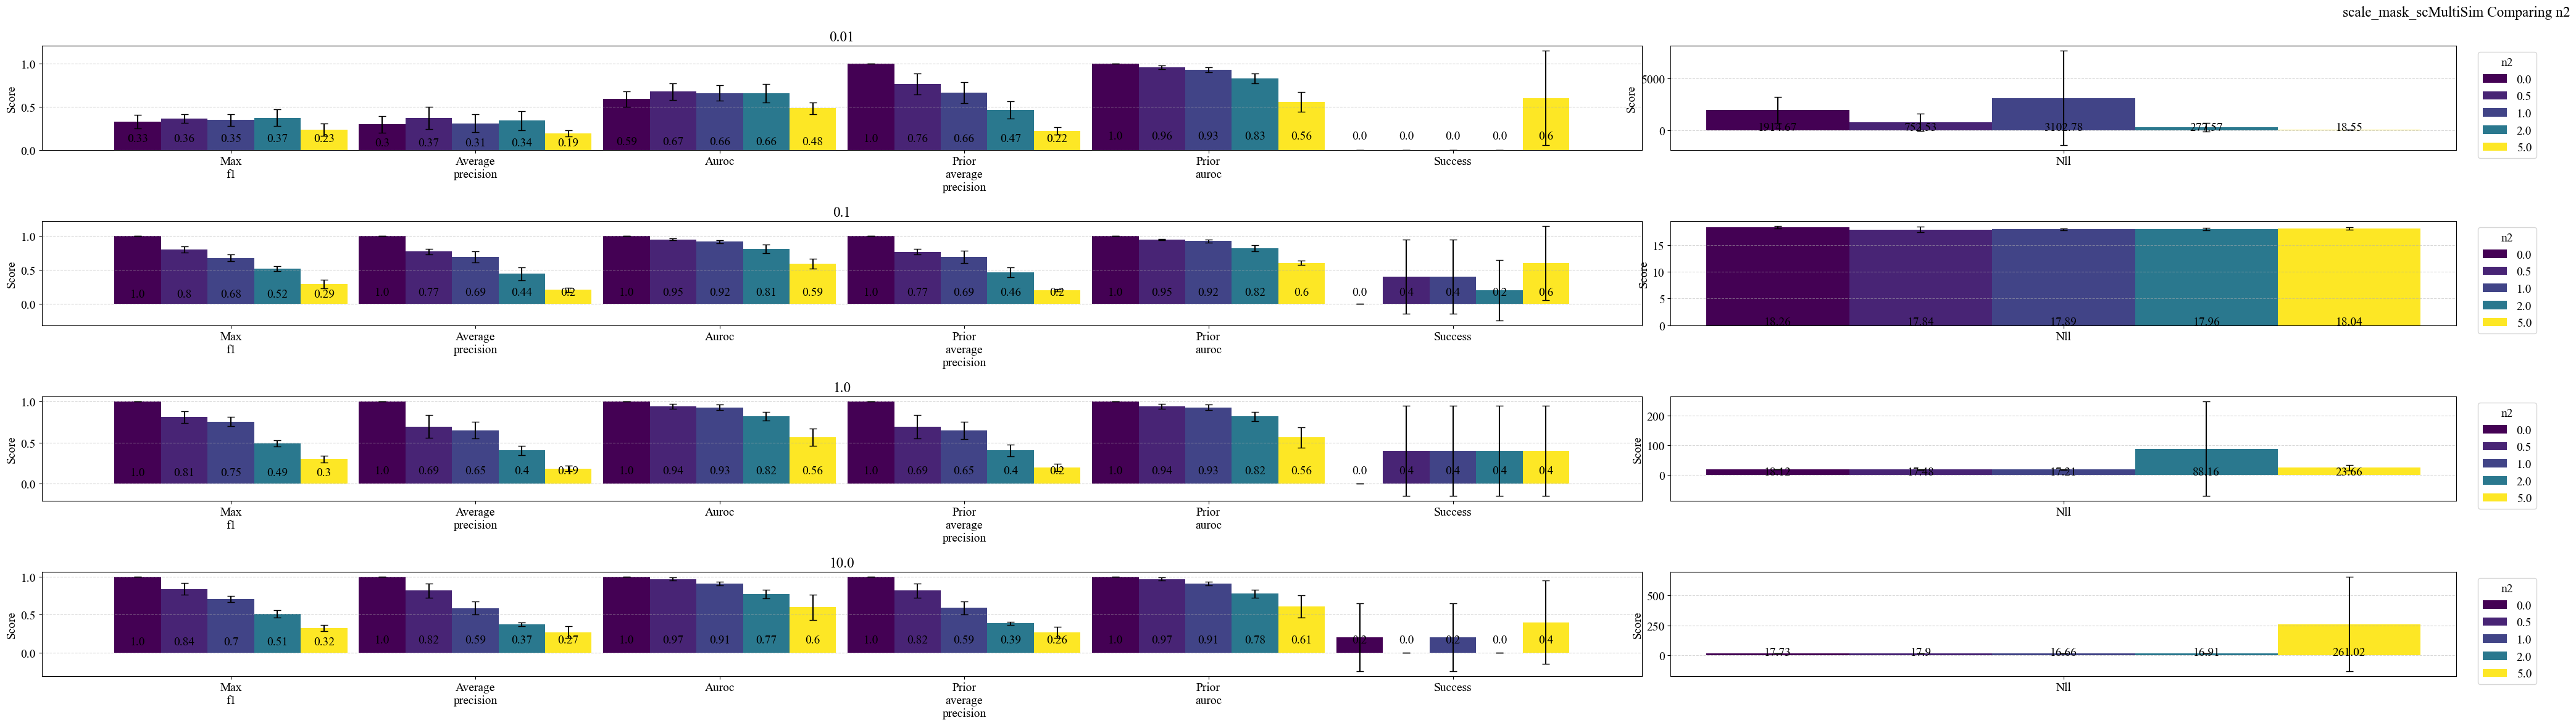

In [23]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
from matplotlib.colors import TABLEAU_COLORS
colors = list(TABLEAU_COLORS.values())
from matplotlib.gridspec import GridSpec
#colors = ["salmon", "skyblue"]
width=4

if "n1" not in params.columns:
    params["n1"] = params["n"]
params["n1"] = params["n1"].astype(float)
params["n2"] = params["n2"].astype(float)
param_of_interest = "n2"
fig = plt.figure(figsize=(width*len(params)*0.2, 12))
gs = GridSpec(len(np.unique(params["n1"])), len(metrics))
for n, a1 in enumerate(np.unique(params["n1"])):
    ax = [fig.add_subplot(gs[n, :-2]), fig.add_subplot(gs[n, -2:])]
    print(a1)
    # Group info
    ex_metrics = [m for m in metrics if m != "nll"] + ["success"]
    df = params.query(f"n1 == {a1}")
    print("df: ",df)

    df = df[ex_metrics+[param_of_interest]]
    
    df = df.dropna(axis=1, how="all")
    df = df.sort_values(param_of_interest)
    p_dict = bar_scientific(df = df, param_of_interest=param_of_interest, ax = ax[0],
                            cmap=plt.get_cmap("viridis"),
                            bar_width=width, annotate=True, legends=False,
                            test=False,
                            )
    
    ex_metrics = ['nll']

    df = params.query(f"n1 == {a1}")[ex_metrics+[param_of_interest]]
    print(f"df: {df}")
    p_dict.update(bar_scientific(df = df, param_of_interest=param_of_interest, ax = ax[1],
                                 cmap=plt.get_cmap("viridis"),
                                 bar_width=width, annotate=True,
                                 test=False
                                 ))
    ax[0].set_title(a1)
    ax[1].legend(bbox_to_anchor=(1.02, 1), title=param_of_interest)
    

fig.suptitle(f"{experiment} Comparing {param_of_interest}")
#fig.legend(labels=np.unique(df[param_of_interest]), labelcolor = colors)
plt.tight_layout()
fig.show()

if save:
    path = f"{experiment}_full_metrics_bar_switch{switch}"
    print(f"Saving! Path: {path}")
    fig.savefig(figures_path/(path +".pdf"))
    with open(figures_path/(path + ".json"), "w") as wf:
        json.dump(p_dict, wf)
    params.to_csv(figures_path/(path+".csv"))
plt.subplots_adjust(right=0.5)

0.0
        model_lr model_n_genes model_n_samples pretraining_time  \
run_027    0.001            10            8000              NaN   
run_025    0.001            10            8000              NaN   
run_001    0.001            10            8000              NaN   
run_076    0.001            10            8000              NaN   
run_078    0.001            10            8000              NaN   
run_079    0.001            10            8000              NaN   
run_002    0.001            10            8000              NaN   
run_053    0.001            10            8000              NaN   
run_029    0.001            10            8000              NaN   
run_051    0.001            10            8000              NaN   
run_077    0.001            10            8000              NaN   
run_026    0.001            10            8000              NaN   
run_003    0.001            10            8000              NaN   
run_050    0.001            10            8000            

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/data/toulouse/miniforge3/envs/bicycle/lib/

metric: prior_auroc
run_012    0.901884
run_010    0.975686
run_011    0.912791
run_014    0.921927
run_013    0.938988
Name: prior_auroc, dtype: float64
run_037    0.946846
run_035    0.916250
run_039    0.892954
run_036    0.950588
run_038    0.916667
Name: prior_auroc, dtype: float64
run_062    0.930980
run_061    0.928000
run_060    0.955285
run_064    0.871102
run_063    0.951992
Name: prior_auroc, dtype: float64
run_088    0.926274
run_087    0.906433
run_089    0.888889
run_086    0.889375
run_085    0.942235
Name: prior_auroc, dtype: float64
unique_df: [ 0.01  0.1   1.   10.  ]
metric: success
run_012    0.0
run_010    0.0
run_011    0.0
run_014    0.0
run_013    0.0
Name: success, dtype: float64
run_037    0.0
run_035    1.0
run_039    0.0
run_036    0.0
run_038    1.0
Name: success, dtype: float64
run_062    0.0
run_061    0.0
run_060    1.0
run_064    1.0
run_063    0.0
Name: success, dtype: float64
run_088    1.0
run_087    0.0
run_089    0.0
run_086    0.0
run_085    0.0
N

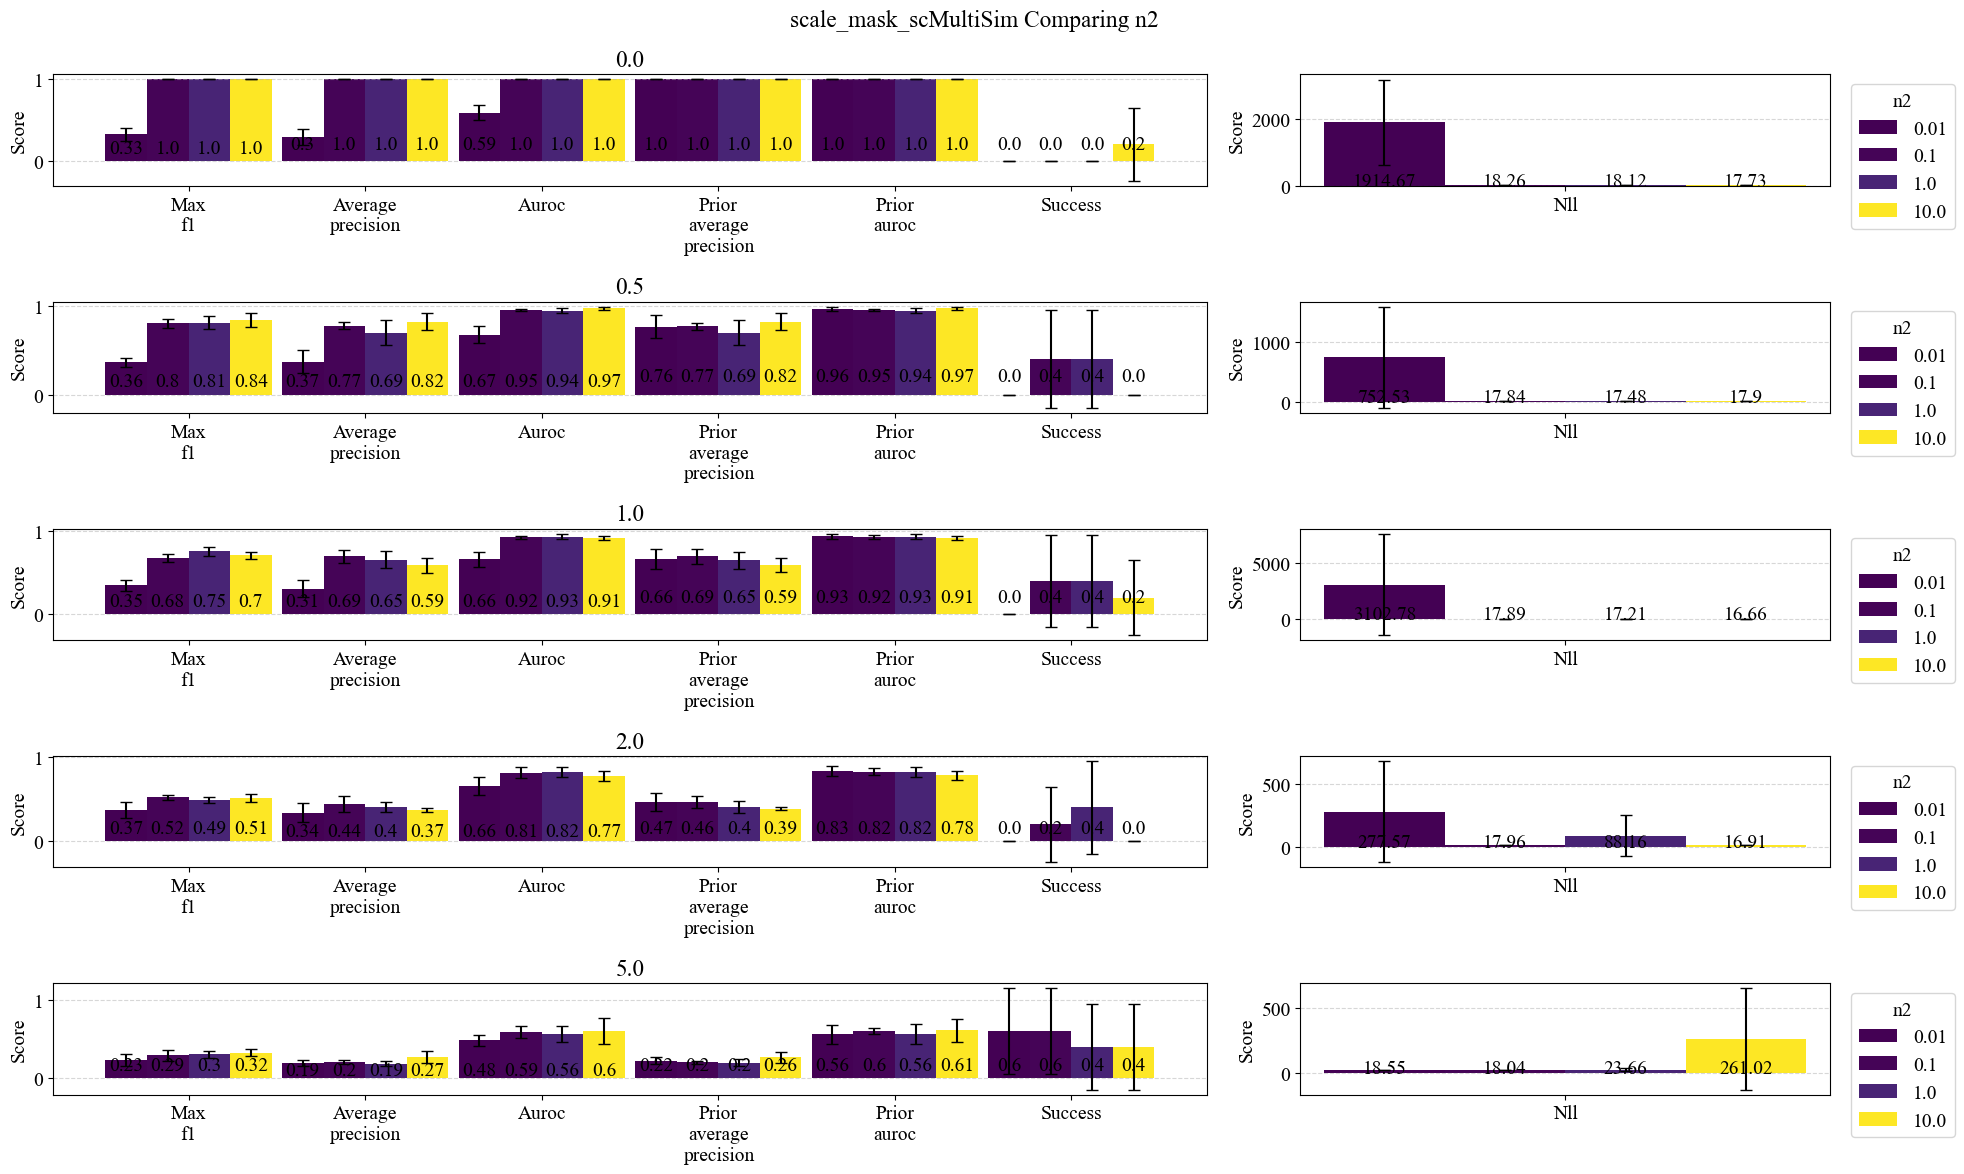

In [24]:
switch=True
if switch:
    n1=params["n1"]
    params["n1"] = params["n2"]
    params["n2"] = n1
if "n1" not in params.columns:
    params["n1"] = params["n"]
params["n1"] = params["n1"].astype(float)
params["n2"] = params["n2"].astype(float)
param_of_interest = "n2"
fig = plt.figure(figsize=(width*len(params)*0.05, 12))
gs = GridSpec(len(np.unique(params["n1"])), 3)
for n, a1 in enumerate(np.unique(params["n1"])):
    ax = [fig.add_subplot(gs[n, :-1]), fig.add_subplot(gs[n, -1])]
    print(a1)
    # Group info
    ex_metrics = [m for m in metrics if m != "nll"] + ["success"]
    df = params.query(f"n1 == {a1}")
    print(df)

    df = df[ex_metrics+[param_of_interest]]
    
    df = df.dropna(axis=1, how="all")
    df = df.sort_values(param_of_interest)
    p_dict = bar_scientific(df = df, param_of_interest=param_of_interest, ax = ax[0], cmap=plt.get_cmap("viridis"), bar_width=width, annotate=True, legends=False, test=False)
    
    ex_metrics = ['nll']

    df = params.query(f"n1 == {a1}")[ex_metrics+[param_of_interest]]
    print(f"df: {df}")
    p_dict.update(bar_scientific(df = df, param_of_interest=param_of_interest, ax = ax[1], cmap=plt.get_cmap("viridis"), bar_width=width, annotate=True, test=False))
    ax[0].set_title(a1)
    ax[1].legend(bbox_to_anchor=(1.02, 1), title=param_of_interest)
        

fig.suptitle(f"{experiment} Comparing {param_of_interest}")
#fig.legend(labels=np.unique(df[param_of_interest]), labelcolor = colors)
plt.tight_layout()
fig.show()

if save:
    path = f"{experiment}_full_metrics_bar_switch{switch}"
    print(f"Saving! Path: {path}")
    fig.savefig(figures_path/(path +".pdf"))
    with open(figures_path/(path + ".json"), "w") as wf:
        json.dump(p_dict, wf)
    params.to_csv(figures_path/(path+".csv"))
if switch:
    n1=params["n1"]
    params["n1"] = params["n2"]
    params["n2"] = n1


In [21]:
params["success"] = params["prior_average_precision"]<params["average_precision"]

In [22]:
params["success"].mean()

0.23

Saving!


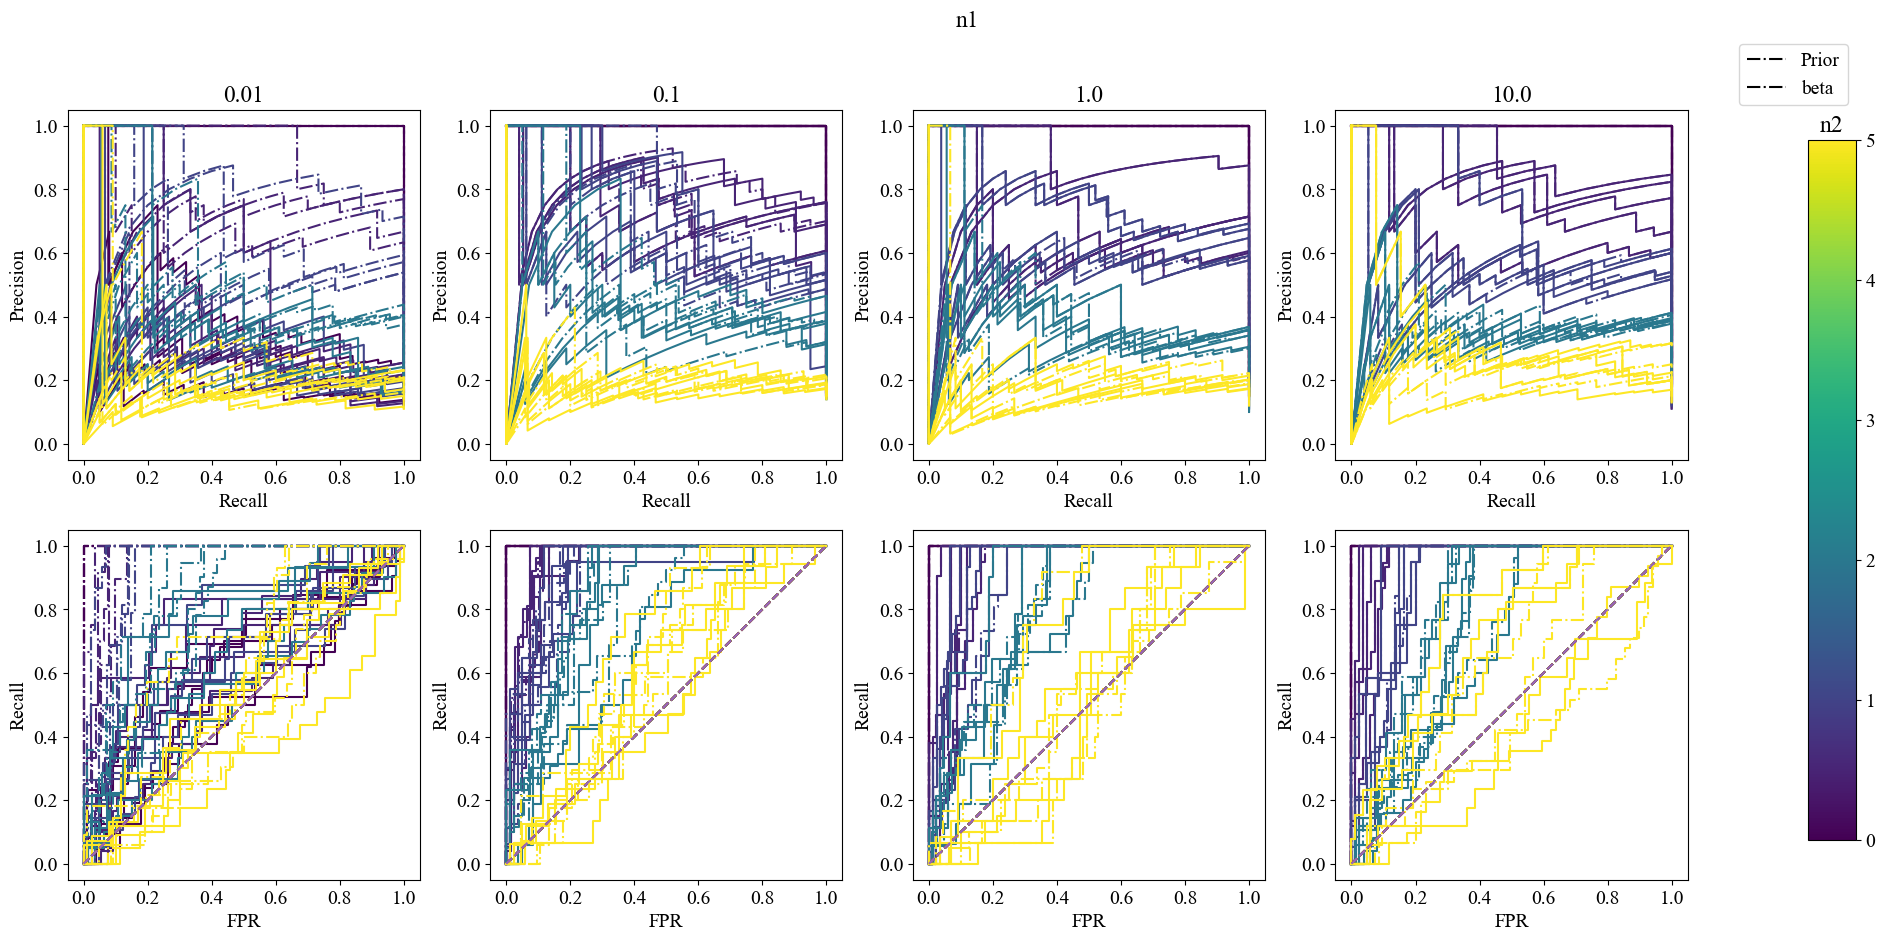

In [25]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
norm = Normalize(vmin=np.min(params["n2"]), vmax=np.max(params["n2"]))
l = len(np.unique(params["n1"]))
fig, ax = plt.subplots(nrows=2, ncols=l, figsize=(l*6, 10))


cmap = plt.get_cmap("viridis")
n=0
for n1 in np.unique(params["n1"]):
    for n2 in np.unique(params["n2"]):
        hits = params[(params["n1"] == n1)*(params["n2"]==n2)]
        for run_id in hits.index:
            max_f1 = False

            with torch.no_grad():
                beta = ckpts[run_id].beta.numpy()
                grn = ckpts[run_id].gt_beta.numpy()
                grn = grn.flatten()
                beta = beta.flatten()
                # normalize to [0, 1]
                grn = (grn > 0).astype(int)
                #beta[beta < 0] = 0
                # center and scale beta
                beta = beta-np.mean(beta)
                beta = beta/np.std(beta)
                beta = expit(beta)
                precision, recall, prc_thresholds = precision_recall_curve(
                    y_true=grn,
                    y_score=beta,
                )
                if ckpts[run_id].bayes_prior != None:
                    prior = ckpts[run_id].bayes_prior.cpu().numpy()
                    prior = prior.flatten()
                    prior[prior < 0] = 0
                    prior = expit(prior)
                    prior_precision, prior_recall,_ = precision_recall_curve(
                        y_true=grn,
                        y_score=prior,
                    )
                    ax[0, n].plot(prior_recall, prior_precision, "-.", color=cmap(norm(n2)))
                    fpr, tpr, roc_thresholds = roc_curve(y_true=grn, y_score=prior)
                    ax[1, n].plot(fpr, tpr, "-.", color=cmap(norm(n2)))

                
                # baseline is positive samples/total samples (saito et al.) = sparsity
                baseline_AUPRC = get_sparsity(grn)

                im = ax[0, n].plot(recall, precision, label=n2, color=cmap(norm(n2)))
                ax[0,n].set_title(n1)
                ax[0, n].set_ylabel("Precision")
                ax[0, n].set_xlabel("Recall")

                fpr, tpr, roc_thresholds = roc_curve(y_true=grn, y_score=beta)
                auroc = auc(fpr, tpr)
                ax[1, n].plot(fpr, tpr, label=n2, color=cmap(norm(n2)))
                ax[1, n].plot([0, 1], [0, 1], "--")

                ax[1, n].set_ylabel("Recall")
                ax[1, n].set_xlabel("FPR")

    n+=1
fig.suptitle("n1")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title("n2")
legend_e = [
    Line2D([0], [0], linestyle="-.", label="Prior", color="black"),
    Line2D([0], [0], linestyle="-.", label="beta", color="black")
            ]
ax[0,-1].legend(handles=legend_e, loc="center", bbox_to_anchor=(1.3, 1.1))
#fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(figures_path/f"{experiment}_metrics_curves.pdf", bbox_inches="tight", pad_inches=0)
fig.show()

Saving!


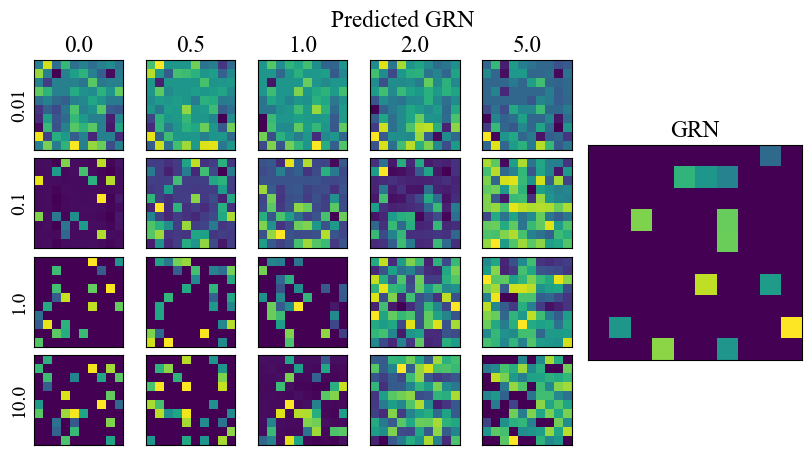

In [28]:
n1_list = np.unique(params["n1"])
n1_list.sort()
n2_list = np.unique(params["n2"])
n2_list.sort()


fig, ax = plt.subplots(nrows=len(n1_list),ncols=len(n2_list)+2, figsize=(10,5))
gs = GridSpec(nrows=len(n1_list),ncols=len(n2_list)+2)
for n1_n, n1 in enumerate(n1_list):
    #ax[n1_n, 0].text(x=-6, y=12, s=n1, rotation=90)
    ax[n1_n, 0].set_ylabel(n1)
    for n2_n, n2 in enumerate(n2_list):
        run_id = params[(params["n1"] == n1)*(params["n2"]==n2)].iloc[0].name
        ax[0, n2_n].set_title(n2)
        ax[(n1_n), n2_n].imshow(ckpts[run_id].beta.detach())
        ax[(n1_n), n2_n].set_yticks([])
        ax[(n1_n), n2_n].set_yticklabels([])
        ax[(n1_n), n2_n].set_xticks([])
        ax[(n1_n), n2_n].set_xticklabels([])
big_ax = fig.add_subplot(gs[:,-2:])
big_ax.imshow(ckpts[run_id].gt_beta)
big_ax.set_title("GRN")
big_ax.set_yticks([])
big_ax.set_xticks([])
for n in ax[:,-2:].flatten():
    n.set_axis_off()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.tight_layout()
fig.suptitle("Predicted GRN")
if save:
    print("Saving!")
    p=f"grns_{experiment}"
    fig.savefig(figures_path/(p+".pdf"))

In [29]:
logs = dict()
for path in models_path.iterdir():
     if path.name[:-id_len] != prefix:
          continue
     logs_path = path / "mylogger/logger.parquet"

     if not logs_path.exists():
         continue
     df = pd.read_parquet(logs_path)
     if "train_mask_loss" in df.columns:
         df["train_mask"]=df["train_mask_loss"]
         df = df.drop(columns="train_mask_loss")
     else:
          df["train_mask"] = np.nan
     df["train_spectral"]=df["train_spectral_loss"]
     df = df.drop(columns="train_spectral_loss")
     df = df.set_index("epoch", drop=True)
     print(len(df["train_loss"]))
     #if len(df["train_loss"]) >5000:
     #     raise NotImplementedError("More than 4999 epochs")
     logs[str(path.name)] = df


5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


Saving!


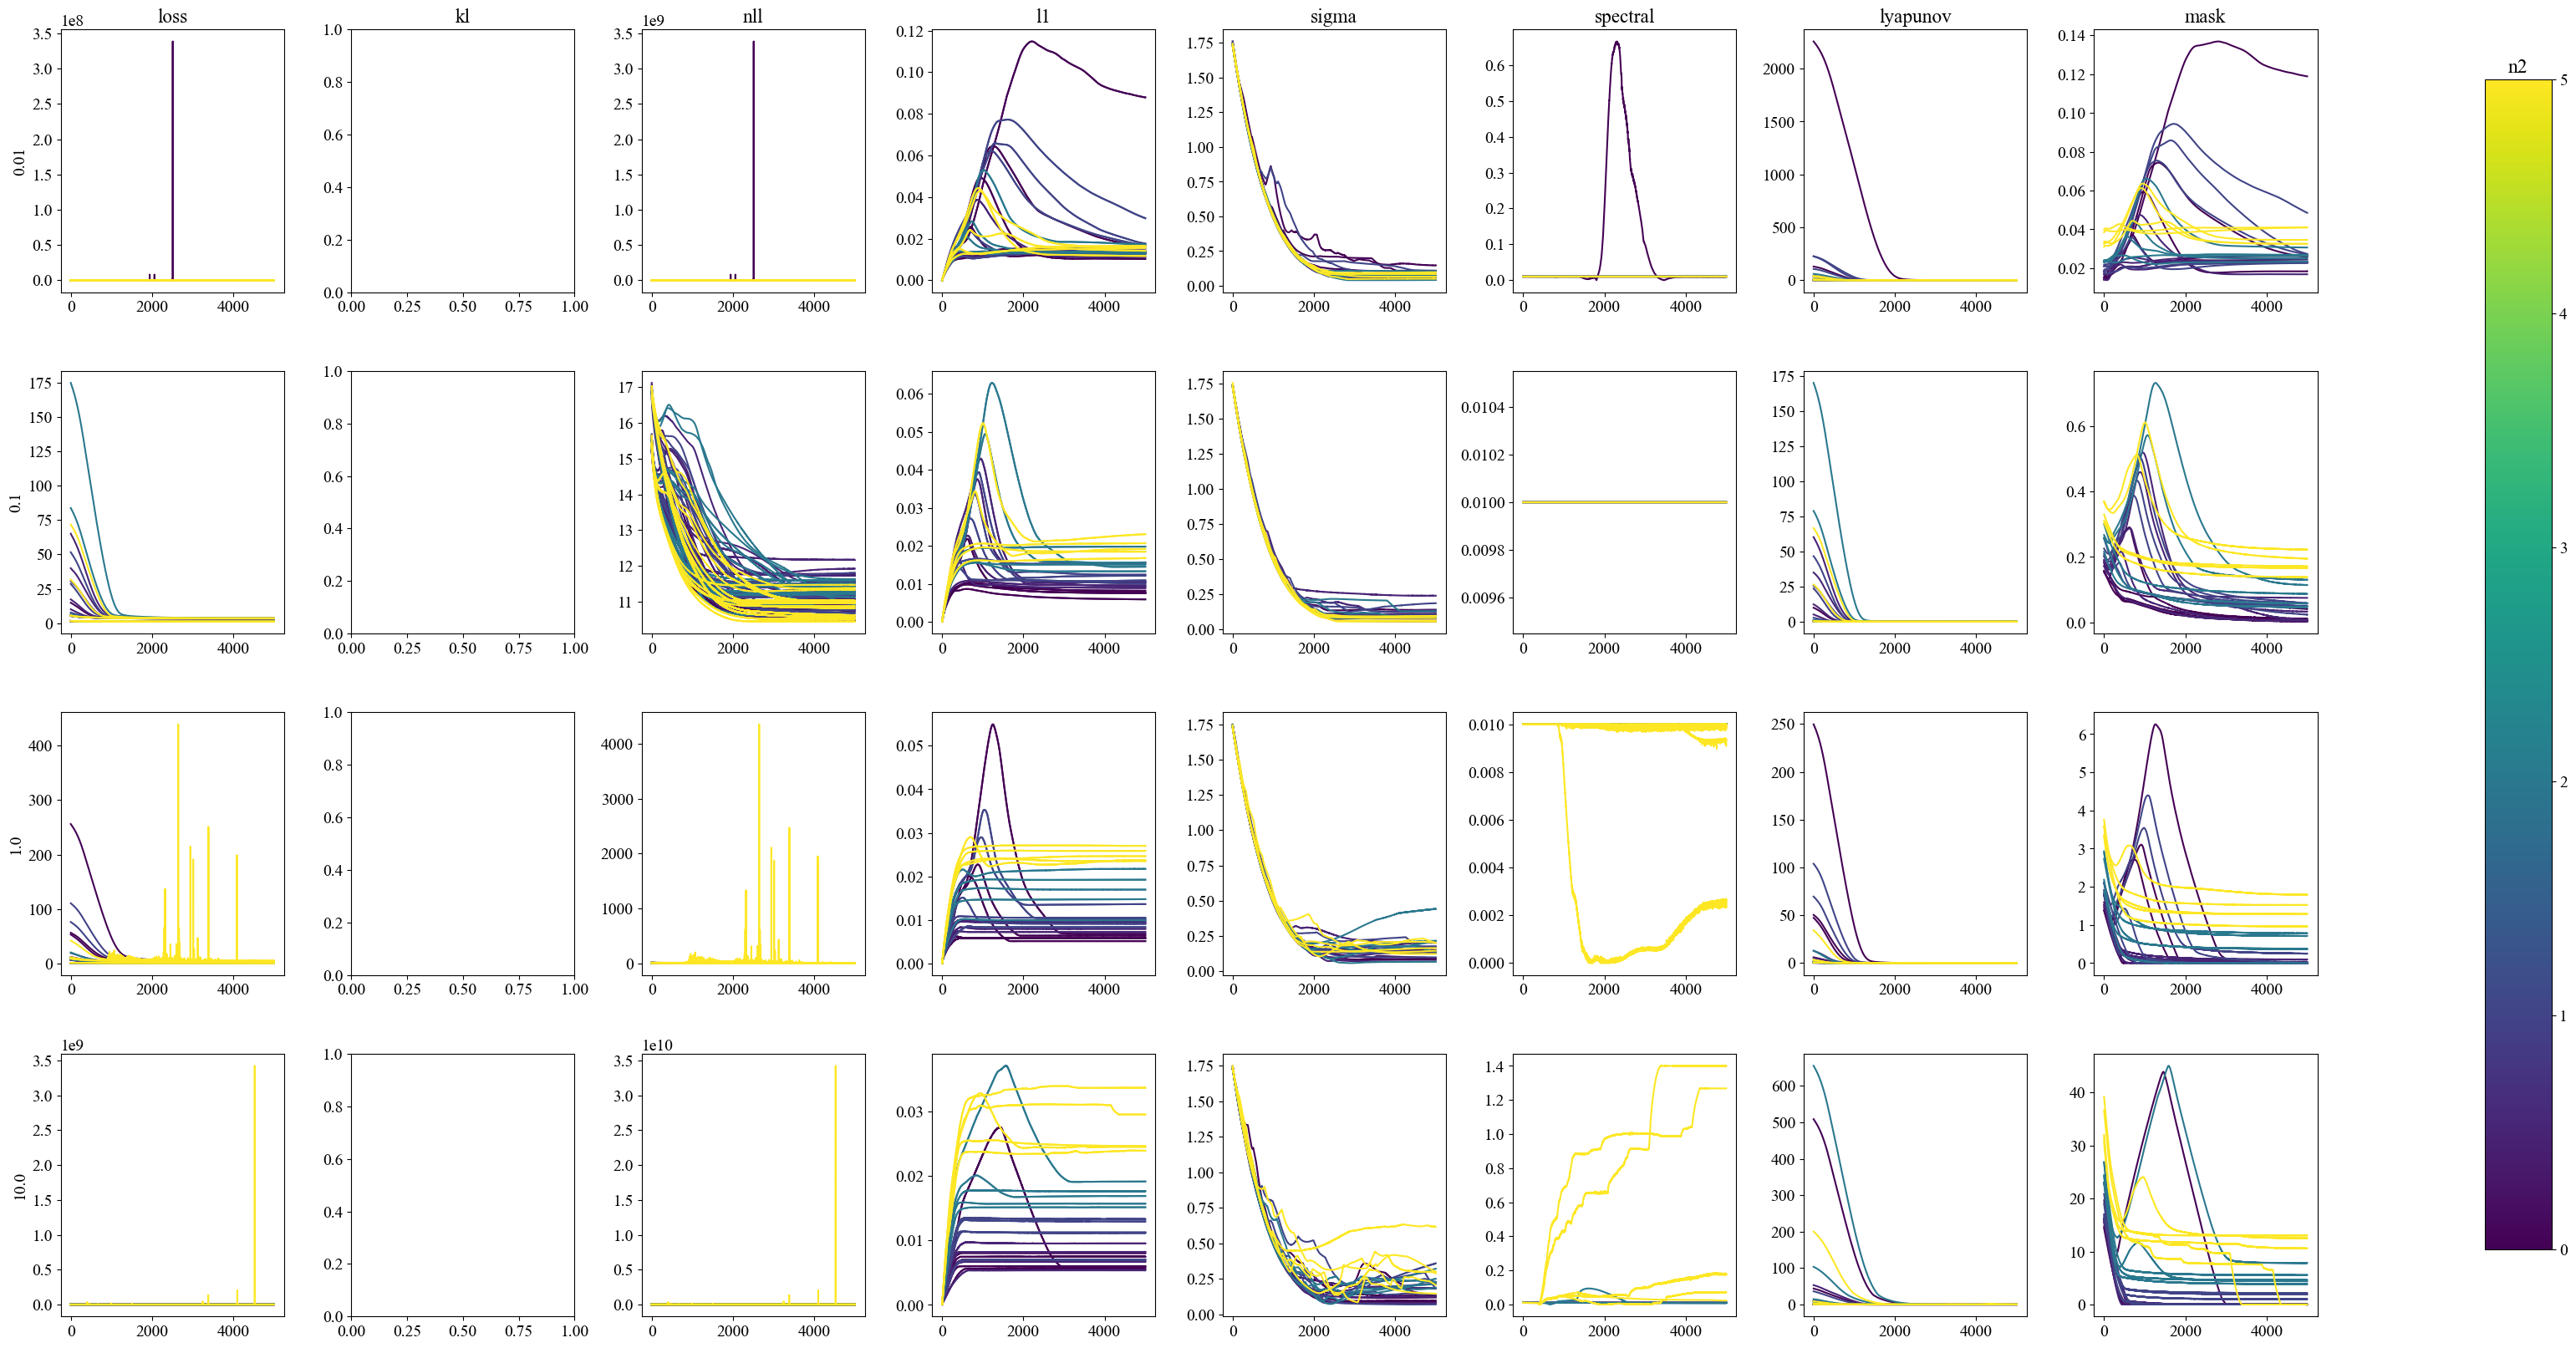

In [30]:

components = ["loss", "kl", "nll", "l1","sigma", "spectral", "lyapunov", "mask"]
norm = Normalize(vmin=np.min(params["n2"]), vmax=np.max(params["n2"]))
l = len(np.unique(params["n1"]))
fig, ax = plt.subplots(nrows=l, ncols=len(components), figsize=(l*10, 20))


cmap = plt.get_cmap("viridis")
n=0
for n1 in np.unique(params["n1"]):
    ax[n, 0].set_ylabel(n1)
    for n2 in np.unique(params["n2"]):
        hits = params[(params["n1"] == n1)*(params["n2"]==n2)]
        for run_id in hits.index:
            df = logs[run_id]
            for c, comp in enumerate(components):
                for x in df.columns:
                    if comp in x:
                        ax[n, c].plot(
                            logs[run_id].index,
                            logs[run_id][x],
                            label=x+"->"+str(n2),
                            c=cmap(norm(n2))
                            )
                #train= comp.replace(".", "train")
                #valid = comp.replace(".", "valid")
                #ax[n, c].plot(
                #    df.index,
                #    df[train],
                #    label=train
                #)
                #ax[n, c].plot(
                #    df.index,
                #    df[valid],
                #    label=valid
                #)
                
        #ax[n, c].set_title(params.loc[run_id,"data_id"])
    n+=1
for c, comp in enumerate(components):
    ax[0,c].set_title(comp)


plt.subplots_adjust(wspace=0.3, hspace=0.3, right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title("n2")
#fig.set_tight_layout("tight")
fig.show()
if save:
    print("Saving!")

    fig.savefig(figures_path/f"{experiment}_{param_of_interest}_loss_tableau.pdf")

Saving!


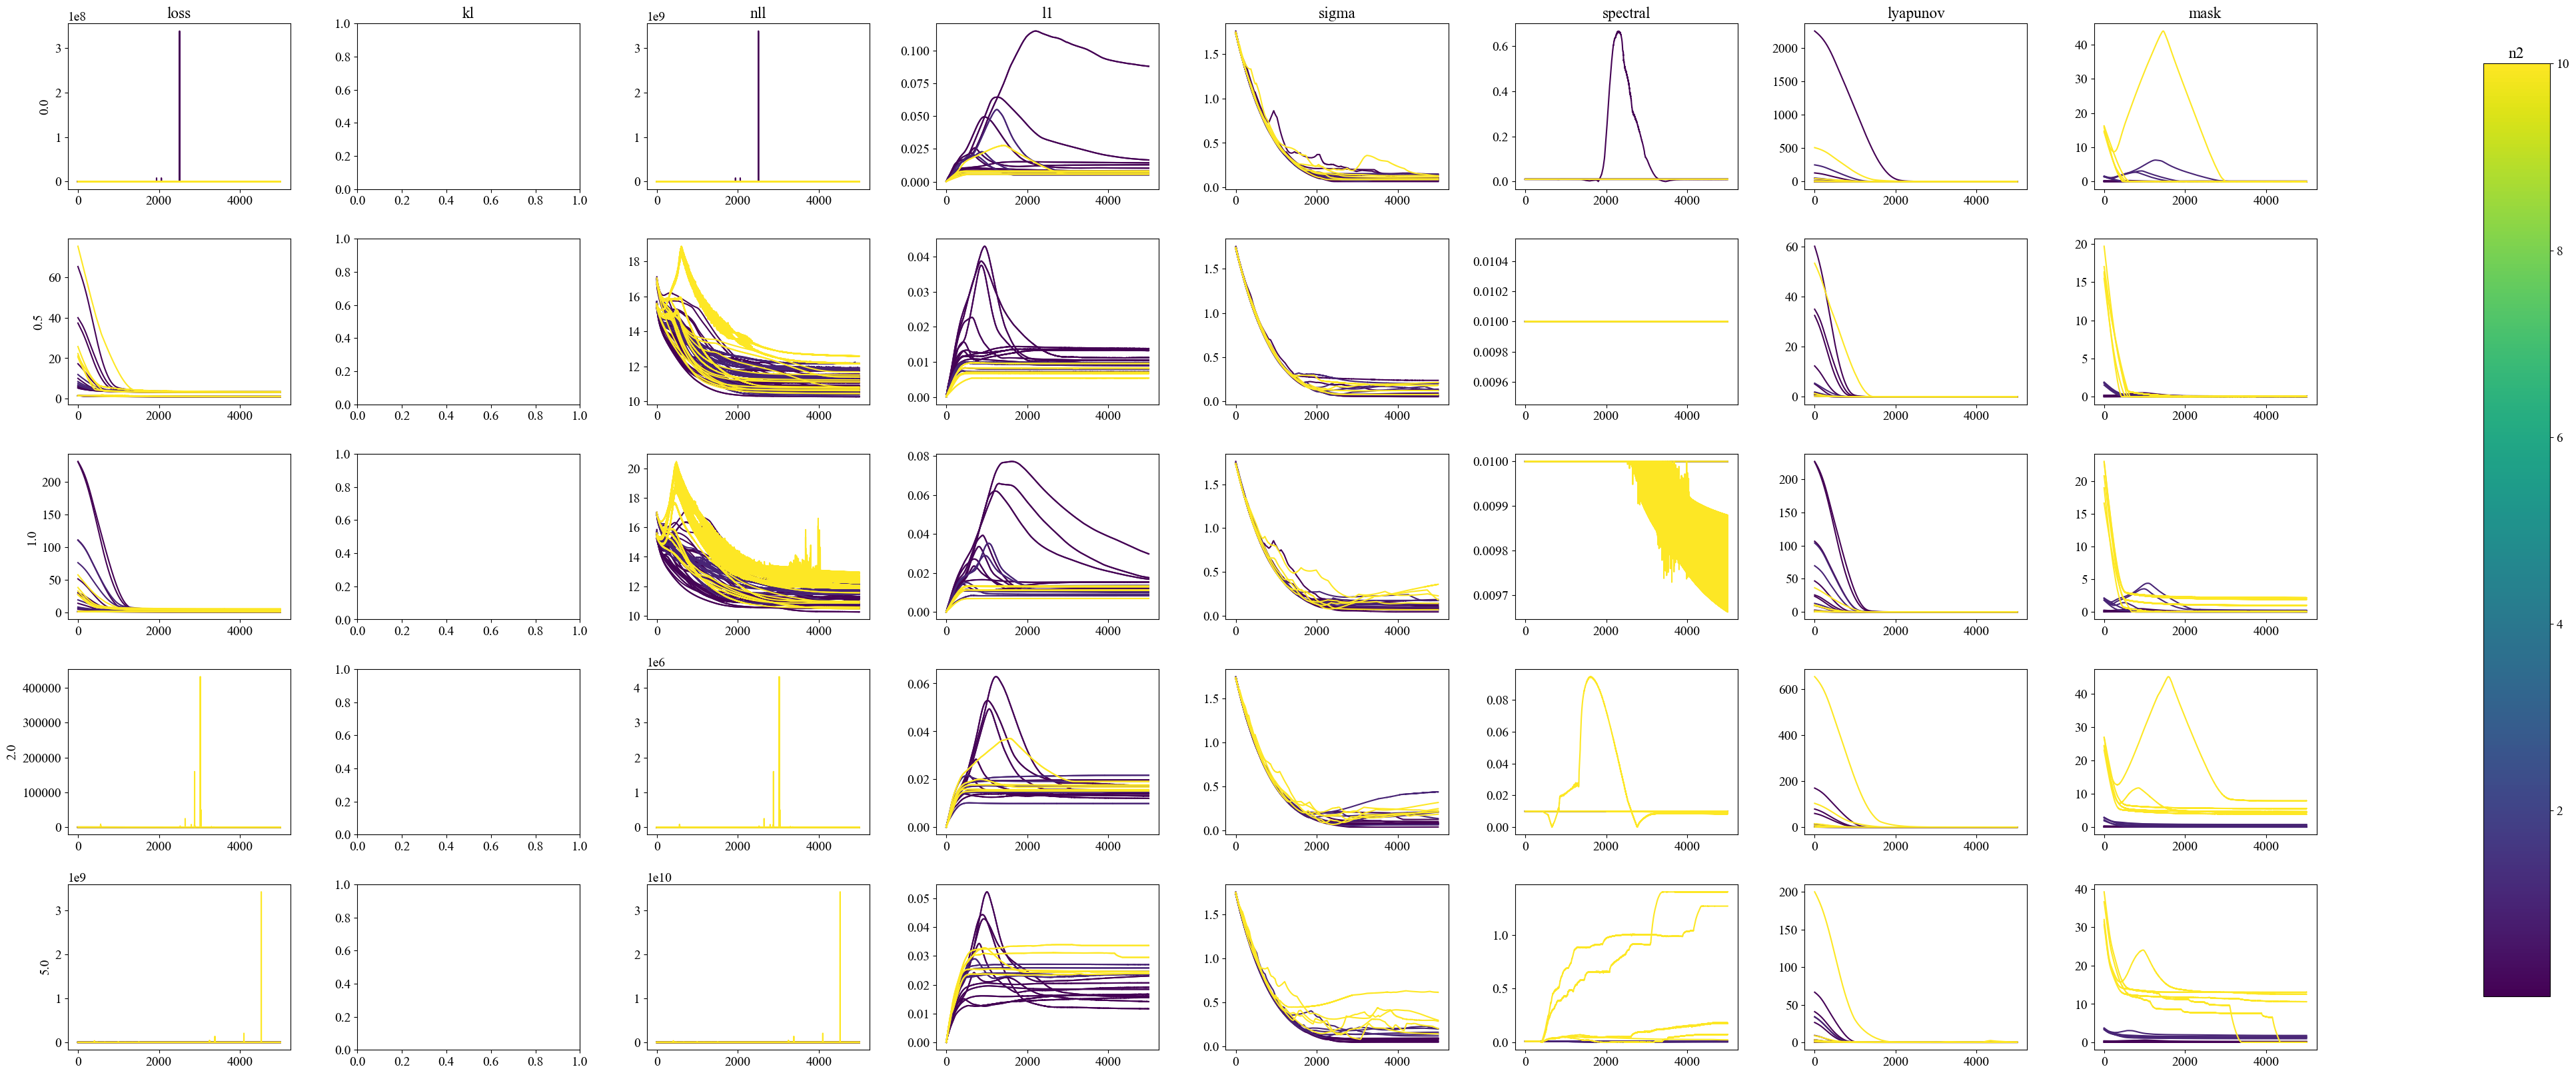

In [31]:
switch=True
if switch:
    n1=params["n1"]
    params["n1"] = params["n2"]
    params["n2"] = n1


norm = Normalize(vmin=np.min(params["n2"]), vmax=np.max(params["n2"]))
l = len(np.unique(params["n1"]))
fig, ax = plt.subplots(nrows=l, ncols=len(components), figsize=(l*10, 20))


cmap = plt.get_cmap("viridis")
n=0
for n1 in np.unique(params["n1"]):
    ax[n, 0].set_ylabel(n1)
    for n2 in np.unique(params["n2"]):
        hits = params[(params["n1"] == n1)*(params["n2"]==n2)]
        for run_id in hits.index:
            df = logs[run_id]
            for c, comp in enumerate(components):
                for x in df.columns:
                    if comp in x:
                        ax[n, c].plot(
                            logs[run_id].index,
                            logs[run_id][x],
                            label=x+"->"+str(n2),
                            c=cmap(norm(n2))
                            )
                #train= comp.replace(".", "train")
                #valid = comp.replace(".", "valid")
                #ax[n, c].plot(
                #    df.index,
                #    df[train],
                #    label=train
                #)
                #ax[n, c].plot(
                #    df.index,
                #    df[valid],
                #    label=valid
                #)
                
        #ax[n, c].set_title(params.loc[run_id,"data_id"])
    n+=1
for c, comp in enumerate(components):
    ax[0,c].set_title(comp)


plt.subplots_adjust(wspace=0.3, hspace=0.3, right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title("n2")
#fig.set_tight_layout("tight")
fig.show()
if save:
    print("Saving!")

    fig.savefig(figures_path/f"{experiment}_{param_of_interest}_loss_tableau_switched.pdf")
if switch:
    n1=params["n1"]
    params["n1"] = params["n2"]
    params["n2"] = n1
switch=False